In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
############
import os
import sys
from packaging import version
import sklearn
import tensorflow as tf

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert version.parse(tf.__version__) >= version.parse("2.8.0")
###########

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
#print("MPS backend available:", tf.backends.mps.is_built())

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU available: []


In [2]:
input_data = pd.read_pickle('../dados/df_ata_sentimento.pkl') 
#input_data = pd.read_json('../dados/df_ata_sentimento.json', orient='records', lines=True)
#input_data['Data'] = pd.to_datetime(input_data['Data']).dt.date
#input_data.tail()
# A obtenção de dados da coluna Selic 6m dixa lacunas, limpar os dados:
input_data = input_data.dropna(subset=['Sentimento','Texto'])
input_data = input_data[~(input_data['Texto'].str.strip().isna() | (input_data['Texto'].str.strip() == ''))]
input_data['Texto'] = input_data['Texto'].str.lower()

input_data.sample(5)

,Data,Texto,Selic,IPCA,Selic (6m),Data (6m),Sentimento
132,2012-07-11,sumário evolução recente da economia avaliação...,8.50,5.20,7.25,2013-01-16,dovish
127,2011-11-30,sumário evolução recente da economia avaliação...,11.50,6.64,9.00,2012-05-30,dovish
13,2000-07-19,sumário demanda e oferta agregadas ambiente ex...,17.00,7.06,16.50,2000-11-22,dovish
68,2005-01-19,sumário evolução recente da inflação avaliação...,17.75,7.41,19.50,2005-05-18,hawkish
2,1999-09-01,sumário demanda e oferta agregadas preços agre...,19.50,5.69,19.00,1999-12-15,dovish


In [3]:
base_data = input_data[['Texto','Sentimento']]

filename_root = 'gru_sentimento_6m_'
subset_dir = '../../subsets/'
model_dir = '../../'
subset_dir = '../../subsets/'
basepickle = subset_dir + filename_root + '__base.pkl'
base_data.to_pickle(basepickle)
print(base_data.sample(5))
print('Records: ',len(base_data))

                                                 Texto Sentimento
124  sumário evolução recente da economia avaliação...     dovish
123  sumário evolução recente da economia avaliação...     dovish
62   sumário evolução recente da inflação avaliação...    hawkish
63   sumário evolução recente da inflação avaliação...    hawkish
225  a atualização da conjuntura econômica e do cen...     dovish
Records:  206


In [4]:
from sklearn.preprocessing import LabelEncoder
#tratamento dos dados para modelo
training_data = base_data.copy()
#Encoding do label alfanumérico
label_encoder = LabelEncoder()
training_data.loc[:, 'sent_encoded'] = label_encoder.fit_transform(training_data['Sentimento'])


# Criando 3 colnuas com hot encoding
one_hot = pd.get_dummies(training_data['Sentimento'], prefix='sent')
training_data = pd.concat([training_data, one_hot], axis=1)

# Renomeando colunas
training_data = training_data.rename(columns={'Texto': 'text'})
training_data = training_data.rename(columns={'Sentimento': 'sent'})

# Display the result
print(training_data.sample(5))

                                                  text     sent  sent_encoded  \
134  sumário evolução recente da economia avaliação...   dovish             0   
43   sumário atividade econômica ambiente externo p...  hawkish             1   
228  a atualização da conjuntura econômica e do cen...  hawkish             1   
100  sumário evolução recente da economia avaliação...  hawkish             1   
132  sumário evolução recente da economia avaliação...   dovish             0   

     sent_dovish  sent_hawkish  sent_neutral  
134         True         False         False  
43         False          True         False  
228        False          True         False  
100        False          True         False  
132         True         False         False  


In [5]:

# Switch de qual label vai ser estudado.
label_set = 'sent_encoded'
#label_set = 'sent_dovish'
#label_set = 'sent_hawkish'
#label_set = 'sent_neutral'

#Globais de processsamento
batch_size = 32
rnd_seed = 63
num_epochs = 180
num_batches = 32
token_count = 30000
padding_size = 80000
embed_size = 128
train_ratio = 0.6
valid_ratio = 0.1

model_file = model_dir + filename_root + '_GRU_0601_modl_' + label_set + '_' + str(num_epochs) + '_mzt_220_B32.keras'
ckpt_file = model_dir + filename_root + '_GRU_0601_chkp_' + label_set + '_' + str(num_epochs) + '_mzt_220_B32.keras'
print(model_file)
print(ckpt_file)

../../gru_sentimento_6m__GRU_0601_modl_sent_encoded_180_mzt_220_B32.keras
../../gru_sentimento_6m__GRU_0601_chkp_sent_encoded_180_mzt_220_B32.keras


In [6]:
from sklearn.model_selection import train_test_split

#Migrando dados parsa dataset TensorFlow
df = pd.DataFrame()
df['text'] = training_data['text'].str.lower()
df['label'] = training_data[label_set]  
print(df.head())

# Convert DataFrame to tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((df['text'].values, df['label'].values))

# Optional: Split into train, validation, and test sets (e.g., 80%/10%/10%)
dataset_size = len(df)
train_size = int(train_ratio * dataset_size)
valid_size = int(valid_ratio * dataset_size)
test_size = dataset_size - train_size - valid_size

# Shuffle the dataset (optional, use a seed for reproducibility)
dataset = dataset.shuffle(buffer_size=dataset_size, seed=rnd_seed)

# Split the dataset
raw_train_set = dataset.take(train_size)
raw_valid_set = dataset.skip(train_size).take(valid_size)
raw_test_set = dataset.skip(train_size + valid_size)

print("Train size:", train_size)
print("Valid size:", valid_size)
print("Test size:", test_size)
# Verify the datasets
for text, label in raw_train_set.take(4):
    print("Text:", text.numpy().decode('utf-8')[:100], "Label:", label.numpy())


                                                text  label
0  sumário preços e nível de atividade agregados ...      0
1  sumário preços e nível de atividade agregados ...      0
2  sumário demanda e oferta agregadas preços agre...      0
3  sumário demanda e oferta agregadas ambiente ex...      0
4  sumário demanda e oferta agregadas ambiente ex...      2
Train size: 123
Valid size: 20
Test size: 63
Text: sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação  Label: 0
Text: sumário evolução recente da inflação avaliação prospectiva das tendências da inflação implementação  Label: 0
Text: sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação  Label: 0
Text: sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação  Label: 0


2025-10-20 18:31:13.064031: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
#Preparar datasets TensorFlow


tf.random.set_seed(rnd_seed)

train_set = raw_train_set.shuffle(100, seed=rnd_seed).batch(batch_size).prefetch(1)
valid_set = raw_valid_set.batch(batch_size).prefetch(1)
test_set = raw_test_set.batch(batch_size).prefetch(1)

for ata, sentiment in raw_train_set.take(4):
    print(ata.numpy().decode("utf-8")[:200], "...")
    print("Sentiment:", sentiment.numpy())

a atualização da conjuntura econômica e do cenário do copom11 o ambiente externo permanece desafiador em função principalmente da conjuntura e da política econômica nos estados unidos o que suscita ma ...
Sentiment: 1
sumário evolução recente da inflação avaliação prospectiva das tendências da inflação implementação da política monetária atividade econômica mercado de trabalho crédito e inadimplência ambiente exter ...
Sentiment: 2
sumário atividade econômica ambiente externo preços mercado monetário e operações de mercado aberto avaliação prospectiva das tendências da inflação diretrizes da política monetária glossário data 16  ...
Sentiment: 1
sumário evolução recente da economia avaliação prospectiva das tendências da inflação implementação da política monetária inflação atividade econômica expectativas e sondagens mercado de trabalho créd ...
Sentiment: 0


2025-10-20 18:31:13.071422: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=token_count)
text_vec_layer.adapt(train_set.map(lambda texts, labels: texts))

#Possibly save vocabulary for later use
# After text_vec_layer.adapt(...) during training
#vocab = text_vec_layer.get_vocabulary()

# Save vocabulary to file
#import pickle
#with open('text_vectorization_vocab.pkl', 'wb') as f:
#    pickle.dump(vocab, f)

# Optionally save config
#config = text_vec_layer.get_config()
#with open('text_vectorization_config.pkl', 'wb') as f:
#    pickle.dump(config, f)


In [9]:
#Masking Automatico



tf.random.set_seed(rnd_seed)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(token_count, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    #tf.keras.layers.Dense(1, activation="sigmoid")# binário
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

# Define callback to save the best model based on validation loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_file,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False
)

# If your labels are integers, convert them to one-hot encoded format
# Assuming train_set and valid_set are tf.data.Dataset objects
def convert_to_one_hot(dataset):
    def process_features_labels(features, labels):
        # Convert integer labels to one-hot encoded labels
        labels = tf.one_hot(labels, depth=3)  # depth=3 for 3 classes
        return features, labels
    return dataset.map(process_features_labels)

# Apply one-hot encoding to datasets
train_set_oh = convert_to_one_hot(train_set)
valid_set_oh = convert_to_one_hot(valid_set)

print("Start: ", datetime.now())
#model.compile(loss="binary_crossentropy", optimizer="nadam",
#              metrics=["accuracy"]) # binário
model.compile(loss="categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(
    train_set_oh,
    validation_data=valid_set_oh,
    epochs=num_epochs,
    callbacks=[checkpoint_cb]
)
print("End: ", datetime.now())

Start:  2025-10-20 18:31:13.194755
Epoch 1/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4959 - loss: 1.0836 - val_accuracy: 0.6500 - val_loss: 1.0440
Epoch 2/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - accuracy: 0.6098 - loss: 1.0543 - val_accuracy: 0.4500 - val_loss: 1.0372
Epoch 3/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.6585 - loss: 0.9897 - val_accuracy: 0.8500 - val_loss: 0.8798
Epoch 4/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.6992 - loss: 0.9100 - val_accuracy: 0.6500 - val_loss: 0.8840
Epoch 5/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.6748 - loss: 0.9057 - val_accuracy: 0.8000 - val_loss: 0.6929
Epoch 6/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5935 - loss: 0.8216 - val_accuracy: 0.6000 - val_loss: 1.0452
Epoch 7/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.7073 - loss: 0.7587 - val_accuracy: 0.8000 - val_loss: 0.6685
Epoch 8/180
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.7317 - loss: 0.6446 - val_a

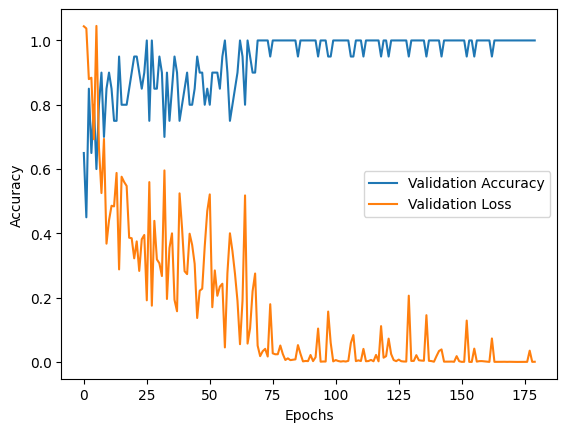

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
#Salvando datasets
test_set_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_test_set"
os.makedirs(test_set_dir, exist_ok=True)
tf.data.Dataset.save(test_set, test_set_dir)
print(test_set_dir)

train_set_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_train_set"
os.makedirs(train_set_dir, exist_ok=True)
tf.data.Dataset.save(train_set, test_set_dir)
print(train_set_dir)

valid_set_dir = subset_dir + filename_root + f"tr_ {train_ratio:.2f}" + "_valid_set"
os.makedirs(valid_set_dir, exist_ok=True)
tf.data.Dataset.save(valid_set, valid_set_dir)
print(valid_set_dir)

../../subsets/gru_sentimento_6m_tr_ 0.60_test_set
../../subsets/gru_sentimento_6m_tr_ 0.60_train_set
../../subsets/gru_sentimento_6m_tr_ 0.60_valid_set


In [17]:
import keras
import os
print(model_file)
keras.saving.save_model(model, model_file)
orgname, ext = name, ext = os.path.splitext(model_file)
vl_model_file = orgname + '_VECLYR_' + ext
model.save(vl_model_file, save_format='tf')
print(vl_model_file)

../../gru_sentimento_6m__GRU_0601_modl_sent_encoded_180_mzt_220_B32.keras
../../gru_sentimento_6m__GRU_0601_modl_sent_encoded_180_mzt_220_B32_VECLYR_.keras


In [21]:
vocab_file = orgname + '_texveclayer_VOCAB.pkl'
config_file = orgname + '_texveclayer_CONFIG.pkl'
print(vocab_file)
print(config_file)

# Save vocabulary to file

vocab = text_vec_layer.get_vocabulary()
with open(vocab_file, 'wb') as f:
    pickle.dump(vocab, f)

# Optionally save config
config = text_vec_layer.get_config()
with open(config_file, 'wb') as f:
    pickle.dump(config, f)


../../gru_sentimento_6m__GRU_0601_modl_sent_encoded_180_mzt_220_B32_texveclayer_VOCAB.pkl
../../gru_sentimento_6m__GRU_0601_modl_sent_encoded_180_mzt_220_B32_texveclayer_CONFIG.pkl


In [14]:
test_set_oh = convert_to_one_hot(test_set)
test_loss, test_accuracy = model.evaluate(test_set_oh)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 5.0056e-04
Test Accuracy: 1.0000
Test Loss: 0.0005


In [15]:
# Step 1: Extract true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_set_oh:
    # Get true labels (one-hot encoded) and convert to class indices
    y_true_batch = tf.argmax(y_batch, axis=1).numpy()  # Convert one-hot to indices
    y_true.extend(y_true_batch)
    
    # Get model predictions and convert to class indices
    y_pred_prob = model.predict(x_batch, verbose=0)  # Predict probabilities
    y_pred_batch = tf.argmax(y_pred_prob, axis=1).numpy()  # Convert to indices
    y_pred.extend(y_pred_batch)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2025-10-20 23:25:40.314070: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


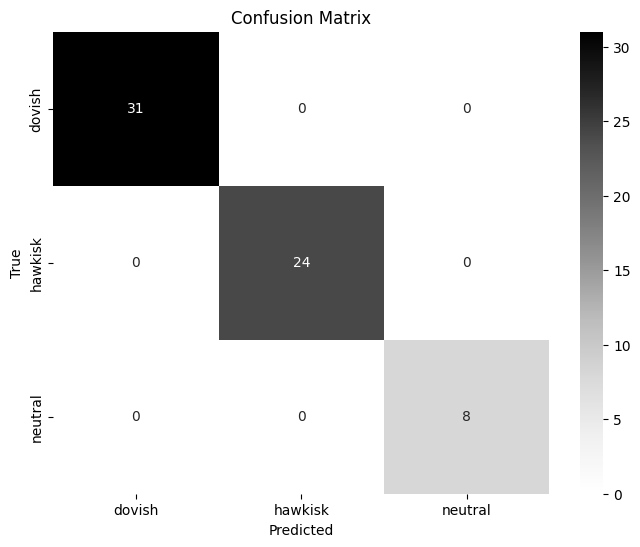

Confusion Matrix:
 [[31  0  0]
 [ 0 24  0]
 [ 0  0  8]]
Classification Report:
              precision    recall  f1-score   support

      dovish       1.00      1.00      1.00        31
     hawkisk       1.00      1.00      1.00        24
     neutral       1.00      1.00      1.00         8

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



In [16]:
#0 = dovish
#1 = hawkisk
#2 = neutral

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Visualize the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Grays', 
            xticklabels=['dovish', 'hawkisk', 'neutral'], 
            yticklabels=['dovish', 'hawkisk', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:\n", cm)
from sklearn.metrics import classification_report
# Define the labels
labels = ['dovish', 'hawkisk', 'neutral']

# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels)

# Print the classification report
print("Classification Report:")
print(report)